In this script, we study the complexity of the real-time representation of the Green's functions that are needed for the Influence Functional (IF). 
The frequency parametrization in the complex plane allows to find an efficient representation of the corresponding integral kernel in terms of the interpolative decomposition (ID).

After computing the kernel decomposition, we visualize various quantities, in particular we study which modes the ID discards and the effective number of modes needed to approximate the IF to a given accuracy.

In [1]:
# Standard Scientific Libraries
import numpy as np
import matplotlib.pyplot as plt

# System and Path Libraries for Module Import
import os
import sys

# Project Path Setup
from setup_project_path import check_and_add_project_path  # Script to check and add project path
check_and_add_project_path()

# Import Custom Modules
from src.utils.module_utils.all_custom_modules import DiscrError,DecompKernel, cf# Consolidated custom modules import
from src.kernel_params.kernel_params import KernelParams

Project path successfully added.


In [2]:
#_____Set Parameters______
params_dict = {
    "m": None,  # to be updated for each computation
    "n": None,  # to be updated for each computation
    "beta": 20.0,  # inverse temperature
    "upper_cutoff": 600.,  # frequency cutoff for continous integrations
    "N_max" : 100,  # nbr of time points
    "delta_t": 0.1, #time step
    "h": None,  # to be updated for each computation
    "phi": np.pi/4,
}  # either "N_max" and "delta_t" OR "times" needs to be specified to define the time grid. If all is specified, the argument "times" is used as time grid

params = KernelParams(**params_dict)
 # array with values of discreitzation parameter, h, which should be explored.
h_vals = np.log(np.arange(2, 1.0, -0.05)) 


In [3]:
#_______Compute continuous integral results________
times = cf.set_time_grid(N_max = params.get_param("N_max"), delta_t=params.get_param("delta_t"))

# create array containing all values for the continuous integration result
cont_integral = cf.cont_integral(t = times, beta = params.get_param("beta"), upper_cutoff = params.get_param("upper_cutoff"), spec_dens = lambda x: 1.0)
        

In [4]:
#_______Evaluate the error between the dicrete-frequency approximation and the continous-frequency integral_____
# create empty array in which to store DiscrError objects
discr_errors = np.empty(shape=(0,), dtype=object)

for h in h_vals:
    params.update_parameters({"h": h})

    discr_error = DiscrError(
        **params.params, cont_integral_init= cont_integral
    )  # DiscrError object which holds the error w.r.t. to the continous results, and all associated parameters.
    
    discr_error.optimize()  # optimize values for m and n

    #Exit the loop it error is below machine precision of if it does not keep shrinking with smaller h. Otherwise, append to array
    if cf.check_error_condition(
        eps_current=discr_error.eps,
        eps_previous=discr_errors[-1].eps if discr_errors.any() else np.infty,
    ):
        break
    else:
        discr_errors = np.append(discr_errors, discr_error)

For h=6.931e-01, beta=20.0, T_max=10.0: Changed frequency limits from [2.51e-30, 4.19e+06] to [3.96e-16, 5.11e+02].
Relative error previously: 1.56e-02, now: 1.56e-02.
For h=6.678e-01, beta=20.0, T_max=10.0: Changed frequency limits from [2.41e-26, 4.69e+06] to [2.02e-14, 4.07e+02].
Relative error previously: 1.35e-02, now: 1.35e-02.
For h=6.419e-01, beta=20.0, T_max=10.0: Changed frequency limits from [7.87e-23, 4.9e+06] to [7.12e-13, 3.22e+02].
Relative error previously: 1.14e-02, now: 1.14e-02.
For h=6.152e-01, beta=20.0, T_max=10.0: Changed frequency limits from [9.69e-20, 4.78e+06] to [1.79e-11, 4.69e+02].
Relative error previously: 9.18e-03, now: 9.18e-03.
For h=5.878e-01, beta=20.0, T_max=10.0: Changed frequency limits from [4.98e-17, 4.34e+06] to [4.98e-17, 3.56e+02].
Relative error previously: 7.41e-03, now: 7.41e-03.
For h=5.596e-01, beta=20.0, T_max=10.0: Changed frequency limits from [2.94e-24, 3.65e+06] to [1.17e-14, 4.70e+02].
Relative error previously: 6.23e-03, now: 6.2

In [5]:
#_____Evaluate the Real-time Kernel and its interpolative decomposition (ID)___
D = np.array([DecompKernel(discr_error, compute_SVD = True) for discr_error in discr_errors]) # Use DiscrError object to initialize the kernel. This ensures that consistency of all parameters.

In [10]:
#____Compute the time-integrated error between the original Green's function and the reconstructed Green's function for all values of h______

propagator_reconstr, propagator_errors = zip(
    *[(D[idx].reconstruct_propagator(), discr_error.error_time_integrated(time_series_approx = D[idx].reconstruct_propagator())) for idx, discr_error in enumerate(discr_errors)]
)

In [11]:
#_______Extract the data that we want to visualize below________
data, kernel_dims = cf.create_numpy_arrays_from_kernel(D)
errors = data["errors"]
m_vals = data["m_vals"]
n_vals = data["n_vals"]
h_vals = data["h_vals"]
N_maxs = data["N_maxs"]
betas = data["betas"]
delta_t_vals = data["delta_t_vals"]
ID_ranks = data["ID_ranks"]

nbr_iterations = len(D)

Below: Plotscripts to visualize the data that has been computed above this point

In [12]:
#_______Set global plot parameters____________
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 8})
cmaps = [plt.get_cmap("Blues"), plt.get_cmap("Reds")]
colors_blue = cmaps[0](np.linspace(0.15, 0.9, nbr_iterations))
colors_orange = cmaps[1](np.linspace(0.15, 0.9, nbr_iterations))

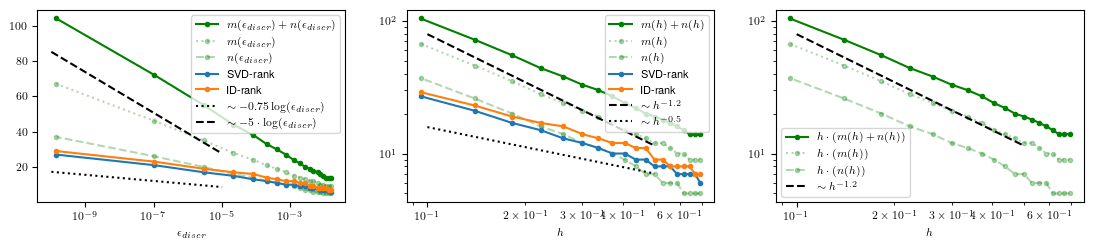

In [13]:
#_____Plot the number of modes versus the error and the discretization parameter h____
fig, axs = plt.subplots(1, 3, figsize=(13.5, 2.5))

axs[0].plot(errors,m_vals + n_vals,color="green",label=r"$m(\epsilon_{discr}) + n(\epsilon_{discr})$",marker="o",linestyle="-",markersize=3)
axs[0].plot(errors,m_vals,color="green",label=r"$m(\epsilon_{discr})$",alpha=0.3,linestyle="dotted",marker="o",markersize=3)
axs[0].plot(errors,n_vals,color="green",label=r"$n(\epsilon_{discr})$",alpha=0.3,linestyle="dashed",marker="o",markersize=3)
axs[0].plot(errors, [d.nbr_sv_above_eps for d in D], label="SVD-rank", marker="o", linestyle="-", markersize=3)
axs[0].plot(errors, ID_ranks, label="ID-rank", marker="o", linestyle="-", markersize=3)
x = np.linspace(1.0e-10, 1.0e-5)
axs[0].plot(x,-0.75 * np.log(x),color="black",linestyle="dotted",label=r"$\sim -0.75\log(\epsilon_{discr})$",)
axs[0].plot(x,-5 * np.log(x) - 30,color="black",linestyle="dashed",label=r"$\sim -5\cdot\log(\epsilon_{discr})$")
axs[0].set_xlabel(r"$\epsilon_{discr}$")
axs[0].legend()
axs[0].set_xscale("log")



axs[1].plot(h_vals,m_vals + n_vals,color="green",label=r"$m(h) + n(h)$",marker="o",linestyle="-",markersize=3)
axs[1].plot(h_vals,m_vals,color="green",label=r"$m(h)$",alpha=0.3,linestyle="dotted",marker="o",markersize=3)
axs[1].plot(h_vals,n_vals,color="green",label=r"$n(h)$",alpha=0.3,linestyle="dashed",marker="o",markersize=3)
axs[1].plot(h_vals, [d.nbr_sv_above_eps for d in D], label="SVD-rank", marker="o", linestyle="-", markersize=3)
axs[1].plot(h_vals, [d.ID_rank for d in D], label="ID-rank", marker="o", linestyle="-", markersize=3)
x = np.logspace(-1, -0.3)
axs[1].plot(x,1 / x ** (1.2) * 5,color="black",linestyle="dashed",label=r"$\sim h^{-1.2}$",)
axs[1].plot(x,1 / np.sqrt(x) * 5,color="black",linestyle="dotted",label=r"$\sim h^{-0.5}$",)
axs[1].set_xlabel(r"$h$")
axs[1].legend()
axs[1].set_xscale("log")
axs[1].set_yscale("log")



axs[2].plot(h_vals,m_vals + n_vals,color="green",label=r"$h \cdot (m(h) + n(h))$",marker="o",linestyle="-",markersize=3)
axs[2].plot(h_vals,m_vals,color="green",label=r"$h \cdot (m(h))$",alpha=0.3,linestyle="dotted",marker="o",markersize=3)
axs[2].plot(h_vals,n_vals,color="green",label=r"$h \cdot (n(h))$",alpha=0.3,linestyle="dashed",marker="o",markersize=3)
x = np.logspace(-1, -0.3)
axs[2].plot(x,1 / x ** (1.2) * 5,color="black",linestyle="dashed",label=r"$\sim h^{-1.2}$")
axs[2].set_xlabel(r"$h$")
axs[2].legend()
axs[2].set_xscale("log")
axs[2].set_yscale("log")


Text(0, 0.5, '$h(\\epsilon_{discr})$')

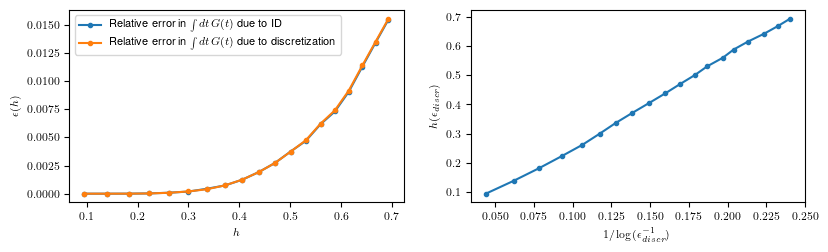

In [14]:
#____COmpare the error due to discretization and the error due to the interpolative decomposition__
#____Study the scaling of the discretization parameter h with 1 / log(1/epsilon) [should be linear for small epsilon]
fig, axs = plt.subplots(1, 2, figsize=(9.5,2.5))


axs[0].plot(h_vals,propagator_errors,label="Relative error in " + r"$\int dt\, G(t)$" + " due to ID",marker="o",linestyle="-",markersize=3,)
axs[0].plot(h_vals,errors,label="Relative error in " + r"$\int dt\,G(t)$" + " due to discretization",marker="o",linestyle="-",markersize=3,)
axs[0].set_xlabel(r"$h$")
axs[0].set_ylabel(r"$\epsilon(h)$")
axs[0].legend()


axs[1].plot(1 / np.log(1 / errors), h_vals, marker="o", linestyle="-", markersize=3)
axs[1].set_xlabel(r"$1/\log(\epsilon_{discr}^{-1})$")
axs[1].set_ylabel(r"$h(\epsilon_{discr})$")

TypeError: 'KernelParams' object is not subscriptable

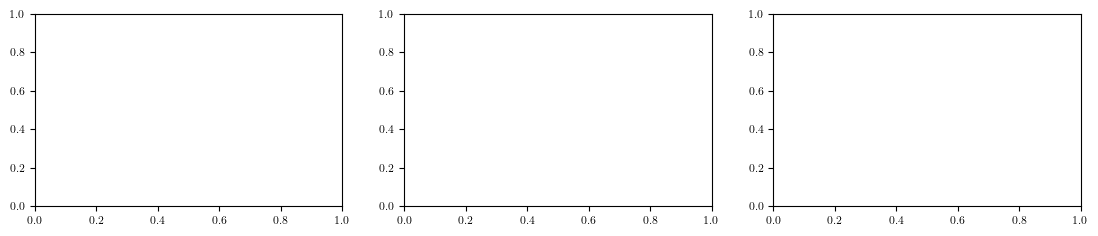

In [15]:
#___________Plot the original couplings as a function of the frequencies on the original fine grid_________
fig, axs = plt.subplots(1, 3, figsize=(13.5,2.5))

for c, d in enumerate(D):
    axs[0].plot(d.fine_grid,1.0 / np.imag(d.fine_grid * np.exp(1.0j * params["phi"])),color=colors_orange[c],)
x = np.linspace(1.0e-6, 70)
axs[0].plot(x,1 / x,linestyle="dotted",label=r"$\sim 1/|\omega_l|$",color="black",)

axs[0].set_xlabel(r"$\omega_k$" + " (Frequencies on fine grid)")
axs[0].set_ylabel(r"$\Gamma(\omega_k) / Im(\omega_k)$")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].legend(loc="lower left")



#___________Plot the effective couplings as a function of the frequencies on the coarse ID grid_________
for c, d in enumerate(D):
    axs[1].plot(
        np.sort(d.coarse_grid),
        np.abs(d.coupl_eff()[np.argsort(d.coarse_grid)] / (np.imag(d.coarse_grid[np.argsort(d.coarse_grid)] * np.exp(1.0j * params.get_param("phi"))))),
        color=colors_orange[c]
    )
x = np.linspace(0.1, 70)
axs[1].plot(x,1 / x,linestyle="dotted",label=r"$\sim 1/|\omega_l|$",color="black",)

axs[1].set_xlabel(r"$\omega_l$" + " (Frequencies on coarse grid)")
axs[1].set_ylabel(r"$|\hat{g}_l| / Im(\omega_l)$")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].legend(loc="lower left")



#___________Plot singular values as function of index_________
for c, d in enumerate(D):
    singular_values = np.delete(d.singular_values, [i for i, sigma in enumerate(d.singular_values) if abs(sigma) < 1.0e-14])
    axs[2].plot(np.arange(len(singular_values)), singular_values, color=colors_orange[c])

axs[2].set_xlabel("Index " + r"$i$")
axs[2].set_ylabel("Singular values " + r"$\Sigma_i$")
axs[2].set_yscale("log")
axs[2].set_ylim(bottom=1.0e-14, top=100)



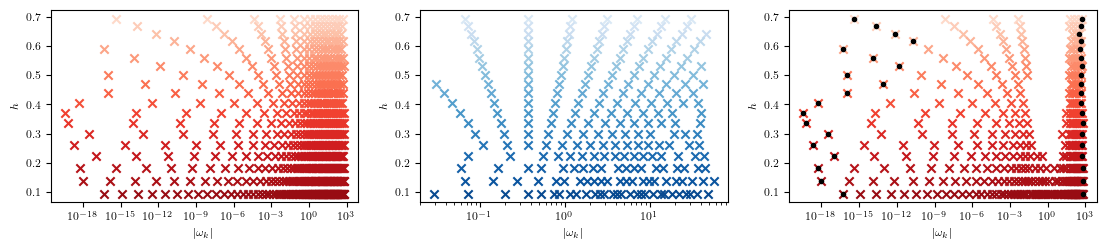

In [16]:
#________Plot the fine grid, the coarse ID grid and their difference_______
fig, axs = plt.subplots(1, 3, figsize=(13.5, 2.5))

for i, h in enumerate(h_vals):
    fine_grid, coarse_grid = D[i].fine_grid, D[i].coarse_grid
    grid_diff = np.setdiff1d(fine_grid, coarse_grid)

    for ax, grid, color, label, marker in zip(axs, [fine_grid, coarse_grid, grid_diff], 
                                              [colors_orange[i], colors_blue[i], colors_orange[i]],
                                              ["", "", ""], ["x", "x", "x"]):
        ax.scatter(grid, len(grid) * [h], color=color, marker=marker, label=label)

    axs[2].scatter([fine_grid[0], fine_grid[-1]], 2 * [h], color="black", marker=".")#plot end points of the fine grid on the difference-grid

for ax in axs:
    ax.set_xscale("log")
    ax.set_xlabel(r"$|\omega_k|$")
    ax.set_ylabel(r"$h$")


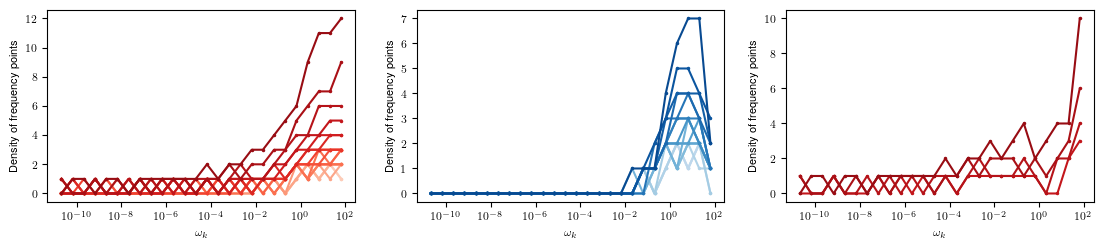

In [17]:
#___Plot the density of frequency points on the fine grid, the coarse grid and the difference-grid____
fig, axs = plt.subplots(1, 3, figsize=(13.5, 2.5))

for i, h in enumerate(h_vals):
    fine_grid, coarse_grid, diff_grid = D[i].fine_grid, D[i].coarse_grid, np.setdiff1d(D[i].fine_grid, D[i].coarse_grid)
    lower_lim, upper_lim, interval_spacing = -11, 2, "log"
    
    for ax, grid, color, marker, markersize in zip(axs, [fine_grid, coarse_grid, diff_grid], 
                                                   [colors_orange[i], colors_blue[i], colors_orange[i] if i > nbr_iterations - 5 else "white"], 
                                                   [".", ".", "."], [3,3,3] if i > nbr_iterations - 5 else [3,3,0]):
        density, density_grid = cf.point_density(grid, lower_lim, upper_lim, interval_spacing)
        ax.plot(density_grid, density, marker=marker, markersize=markersize, color=color)

for ax in axs:
    ax.set_xscale("log")
    ax.set_xlabel(r"$\omega_k$")
    ax.set_ylabel("Density of frequency points")
